## Description:

Compare OTUs that vary in rhizosphere and vary in bare soil by date and test for correlation


# Setting variables

In [2]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
respFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/Responders.txt'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.3’
[1] "BiocParallel"
[1] ‘1.0.3’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.6.3’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.1.0’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.0’
[1] "metagenomeSeq"
[1] ‘1.11.10’
[1] "phyloseq"
[1] ‘1.10.0’
[1] "dplyr"
[1] ‘0.4.3’
[1] "tidyr"
[1] ‘0.4.1’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.3.5’


In [5]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [6]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


# Do bare soil samples change with date?

In [7]:
%%R
#loading rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.R = readRDS(F)

physeq.Rb = subset_samples(physeq.R, Type == "BARE")
physeq.Rb

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 64 samples ]
sample_data() Sample Data:       [ 64 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [8]:
%%R
# calculate weighted and unweighte uni-frac distances
registerDoParallel(cores=28)
bare.wunif.dist = distance(physeq.Rb, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

bare.unif.dist = distance(physeq.Rb, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [9]:
%%R -w 800 -h 350
# Generate NMDS for 
sample_data(physeq.Rb)$DAP = factor(sample_data(physeq.Rb)$DAP)

sample_data(physeq.Rb)$Rep = factor(sample_data(physeq.Rb)$Rep)

nmds_w = ordinate(physeq.Rb, 
                method = "NMDS", 
                distance = bare.wunif.dist)

nmds_u = ordinate(physeq.Rb, 
                method = "NMDS", 
                distance = bare.unif.dist)


Run 0 stress 0.1536947 
Run 1 stress 0.1931291 
Run 2 stress 0.154154 
... procrustes: rmse 0.02029298  max resid 0.1404421 
Run 3 stress 0.1536989 
... procrustes: rmse 0.001068678  max resid 0.006350352 
*** Solution reached
Run 0 stress 0.2936809 
Run 1 stress 0.2995274 
Run 2 stress 0.3070041 
Run 3 stress 0.3014532 
Run 4 stress 0.3012594 
Run 5 stress 0.2989406 
Run 6 stress 0.2942634 
Run 7 stress 0.3027233 
Run 8 stress 0.2945801 
Run 9 stress 0.3016291 
Run 10 stress 0.30546 
Run 11 stress 0.3004382 
Run 12 stress 0.3067836 
Run 13 stress 0.3031365 
Run 14 stress 0.2945259 
Run 15 stress 0.3003109 
Run 16 stress 0.2994282 
Run 17 stress 0.3021874 
Run 18 stress 0.302866 
Run 19 stress 0.297228 
Run 20 stress 0.2991542 


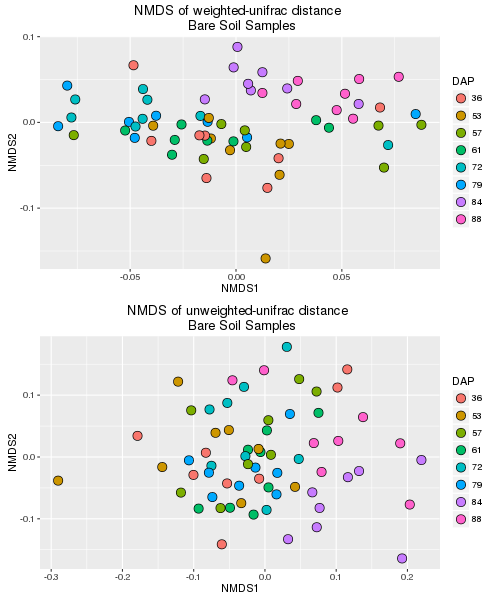

In [10]:
%%R -w 500 -h 600
p = plot_ordination(physeq.Rb, nmds_w, justDF = TRUE)
p_u = plot_ordination(physeq.Rb, nmds_u, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=DAP), pch = 21, size = 4) +
        ggtitle("NMDS of weighted-unifrac distance \n Bare Soil Samples")
        #scale_size(range=c(2,8))


p2 = ggplot(p_u, aes(x = NMDS1, y = NMDS2)) +
       geom_point(aes(fill=DAP), pch=21, size = 4) +
        ggtitle("NMDS of unweighted-unifrac distance \n Bare Soil Samples")
        #scale_size(range=c(2,8))

grid.arrange(p1, p2, ncol=1)

In [11]:
%%R
set.seed(1)

df = as(sample_data(physeq.Rb), "data.frame")

#weighted unifrac
d = bare.wunif.dist
Bareadonis = adonis(formula = d ~ Library + Treatment + DAP, df, strata = df$Rep, permutations = 999)
print("PERMANOVA of bare soil samples with w-unifrac")
Bareadonis %>% print

#weighted unifrac
d = bare.unif.dist
Bareadonis = adonis(formula = d ~ Library + Treatment + DAP, df, strata = df$Rep, permutations = 999)
print("PERMANOVA of bare soil samples with unifrac")
Bareadonis %>% print




[1] "PERMANOVA of bare soil samples with w-unifrac"

Call:
adonis(formula = d ~ Library + Treatment + DAP, data = df, permutations = 999,      strata = df$Rep) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Library    1   0.08972 0.089724 13.4905 0.16288  0.001 ***
Treatment  1   0.00612 0.006124  0.9207 0.01112  0.458    
DAP        7   0.09587 0.013695  2.0591 0.17403  0.001 ***
Residuals 54   0.35915 0.006651         0.65198           
Total     63   0.55086                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "PERMANOVA of bare soil samples with unifrac"

Call:
adonis(formula = d ~ Library + Treatment + DAP, data = df, permutations = 999,      strata = df$Rep) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      

* MCC in bare soil samples change by date in both weighted and un-weighted unifrac estimates
* Effect is robust to inclusion of library in permanova

## Filter taxa to rhizosphere responders


In [12]:
%%R -i respFile
Responders = read.table(respFile, header = FALSE, sep = "\t")
colnames(Responders) = c("OTU", "Resp")
Responders = filter(Responders, Resp == 1, TRUE)

In [13]:
%%R
Rsel = as.character(Responders[,1])
head(Rsel)

[1] "OTU.10"    "OTU.100"   "OTU.1000"  "OTU.10009" "OTU.1001"  "OTU.10030"


In [14]:
%%R

#re-order levels 
sample_data(physeq.Full)$Plant = relevel(sample_data(physeq.Full)$Plant, "BARE")

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$DAP %>% levels %>% print

#sample_data(physeq.Full)$PlantRep = interaction(sample_data(physeq.Full)$Rep, sample_data(physeq.Full)$Plant)


[1] "36" "53" "57" "61" "72" "79" "84" "88"


In [15]:
%%R
physeq.Resp = prune_taxa(Rsel, physeq.Full)
physeq.Resp = subset_samples(physeq.Resp, Library == 1, TRUE)
sample_data(physeq.Resp)$DAP %>% levels %>% print
sample_data(physeq.Resp)$Plant %>% levels %>% print

[1] "36" "53" "57" "61" "72" "79"
 [1] "75-062" "AMAPO"  "B73"    "B97"    "BARE"   "ERATE"  "FAGES"  "GLYMA" 
 [9] "H99"    "Il14H"  "MS71"   "Oh7B"   "SETFA" 


In [16]:
%%R
## Create phyloseq object on subset of samples
physeq.plant = subset_samples(physeq.Resp, Plant != "BARE")
sample_data(physeq.plant)$PlantRep = interaction(sample_data(physeq.plant)$Rep, sample_data(physeq.plant)$Plant)

In [17]:
%%R
physeq.bare = subset_samples(physeq.Resp, Plant == "BARE")
sample_data(physeq.bare)$DAPRep = interaction(sample_data(physeq.bare)$Rep, sample_data(physeq.bare)$DAP)
physeq.bare

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1506 taxa and 40 samples ]
sample_data() Sample Data:       [ 40 samples by 56 sample variables ]
tax_table()   Taxonomy Table:    [ 1506 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1506 tips and 1505 internal nodes ]


# still need to try removing library 2

# Create DESeq object and view results for Bare and Planted Seperately

## Test for log2fold change by date from 72 as benchmark

In [18]:
%%R
dds = phyloseq_to_deseq2(physeq.bare, ~Rep + Treatment + DAP)
d_dds = DESeq(dds, parallel = TRUE)
#B.88 = results(d_dds, contrast = c("DAP", "72", "88"))
#B.84 = results(d_dds, contrast = c("DAP", "72", "84"))
B.79 = results(d_dds, contrast = c("DAP", "72", "79"))
B.61 = results(d_dds, contrast = c("DAP", "72", "61"))
B.57 = results(d_dds, contrast = c("DAP", "72", "57"))
B.53 = results(d_dds, contrast = c("DAP", "72", "53"))
B.36 = results(d_dds, contrast = c("DAP", "72", "36"))


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating size factors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating dispersions

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: gene-wise dispersion estimates: 20 workers

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: mean-dispersion relationship

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

In [19]:
%%R
dds = phyloseq_to_deseq2(physeq.plant, ~Rep + Treatment + DAP)
d_dds = DESeq(dds, parallel = TRUE)
#R.88 = results(d_dds, contrast = c("DAP", "72", "88"))
#R.84 = results(d_dds, contrast = c("DAP", "72", "84"))
R.79 = results(d_dds, contrast = c("DAP", "72", "79"))
R.61 = results(d_dds, contrast = c("DAP", "72", "61"))
R.57 = results(d_dds, contrast = c("DAP", "72", "57"))
R.53 = results(d_dds, contrast = c("DAP", "72", "53"))
R.36 = results(d_dds, contrast = c("DAP", "72", "36"))

## Join tables and graph

### Days

In [20]:
%%R
#join results tables in a single table
R = R.36
B = B.36
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Rhiz_baseMean > 30 , TRUE)
p.36 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
ggtitle("72 vs 36")



In [21]:
%%R
#join results tables in a single table
R = R.53
B = B.53
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.53 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
    ggtitle("72 vs 53")


In [22]:
%%R
#join results tables in a single table
R = R.57
B = B.57
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.57 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
    ggtitle("72 vs 57")


In [23]:
%%R
#join results tables in a single table
R = R.61
B = B.61
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.61 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") + 
    ggtitle("Day 72 vs 61")


In [24]:
%%R
#join results tables in a single table
R = R.79
B = B.79
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.72 = ggplot(Tbl.f, aes(x = log(Bare_baseMean), y = log(Rhiz_baseMean))) +
    geom_point()+
    stat_smooth(method = "lm") +
ggtitle("Day 72 vs 72")


In [25]:
%%R
#join results tables in a single table
R = R.79
B = B.79
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.79 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
ggtitle("Day 72 vs 79")


In [26]:
%%R
# #join results tables in a single table
# R = R.84
# B = B.84
# colnames(R) = paste("Rhiz_", colnames(R), sep ="")
# colnames(B) = paste("Bare_", colnames(B), sep ="")
# R = as.data.frame(R[,c(1,2,5,6)])
# B= as.data.frame(B[,c(1,2,5,6)])
# R$OTU = row.names(R)
# B$OTU = row.names(B)
# Tbl = inner_join(B, R, by = "OTU")                                   

# # Graph
# Tbl.f = filter(Tbl, Bare_baseMean > 2 , TRUE)
# p.84 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
#     geom_point()+
#     stat_smooth(method = "lm") +
#     ggtitle("Day 72 vs 84 \n Warning Different Libraries")


NULL


In [27]:
%%R
# #join results tables in a single table
# R = R.88
# B = B.88
# colnames(R) = paste("Rhiz_", colnames(R), sep ="")
# colnames(B) = paste("Bare_", colnames(B), sep ="")
# R = as.data.frame(R[,c(1,2,5,6)])
# B= as.data.frame(B[,c(1,2,5,6)])
# R$OTU = row.names(R)
# B$OTU = row.names(B)
# Tbl = inner_join(B, R, by = "OTU")                                   

# # Graph
# Tbl.f = filter(Tbl, Bare_baseMean > 2 , TRUE)
# p.88 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
#     geom_point()+
#     stat_smooth(method = "lm") +
#     theme(legend.position = "none") +
#     ggtitle("Day 72 vs 88 \n Warning Different Libraries")


NULL


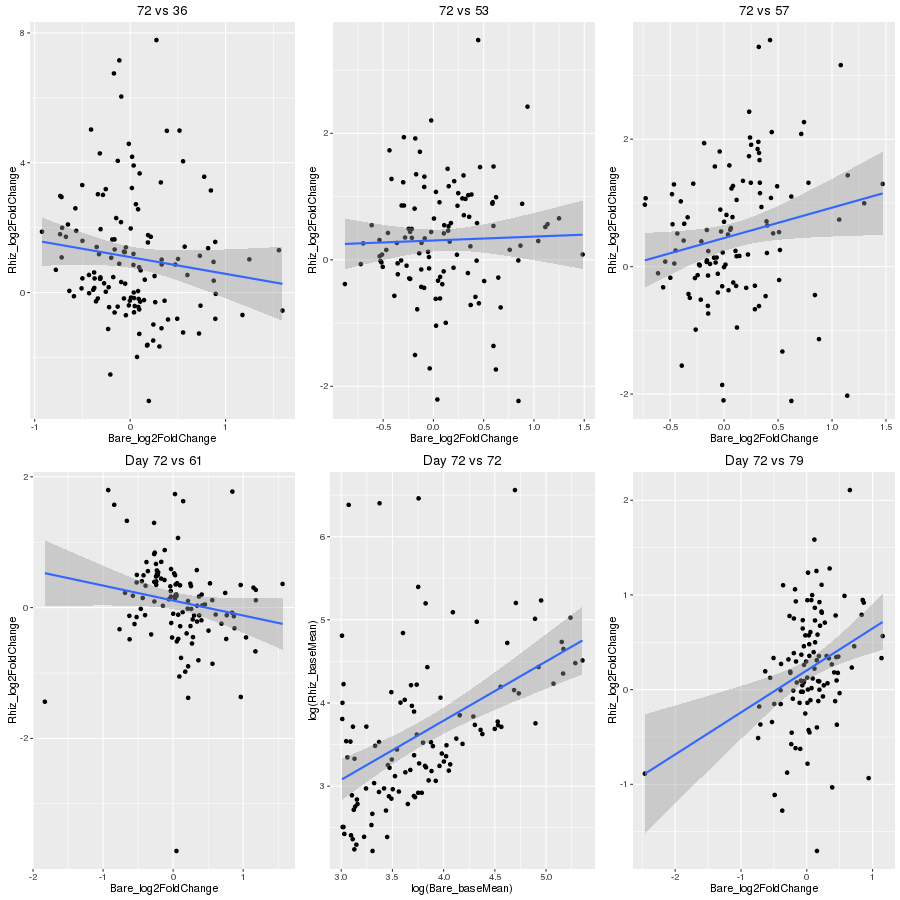

In [28]:
%%R -w 900 -h 900
grid.arrange(p.36, p.53, p.57, p.61, p.72, p.79, ncol = 3)

## Are DAP responders in bare soil the same as those in Rhizosphere

In [35]:
%%R
physeq.Resp = prune_taxa(Rsel, physeq.Full)
#physeq.Resp = subset_samples(physeq.Resp, Library == 1, TRUE)
sample_data(physeq.Resp)$DAP %>% levels %>% print
sample_data(physeq.Resp)$Plant %>% levels %>% print

#subset to bare and plant files
physeq.plant = subset_samples(physeq.Resp, Plant != "BARE")
physeq.bare = subset_samples(physeq.Resp, Plant == "BARE")

[1] "36" "53" "57" "61" "72" "79" "84" "88"
 [1] "BARE"   "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR" 
 [9] "ERATE"  "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"   
[17] "Mo18"   "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 


# First order DAP shifts

In [36]:
%%R
phy = subset_samples(physeq.plant, Type != "Maize" | Plant == "B73")
sample_data(phy)$DAP =  sample_data(phy)$DAP %>% as.character %>% as.numeric
dds = phyloseq_to_deseq2(phy, ~ Library + DAP)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 33 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: fitting model and testing

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept" "Library"   "DAP"      


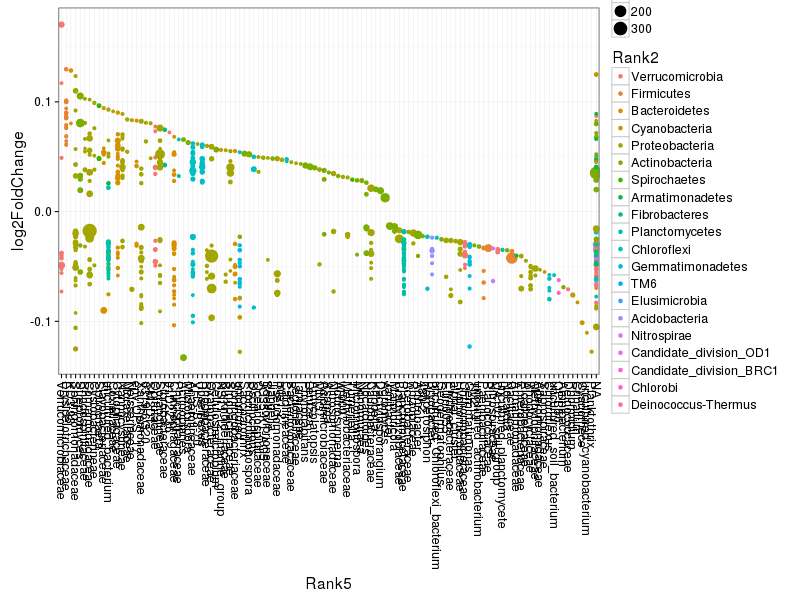

In [37]:
%%R -w 800 -h 600
sigtab = DF %>% filter(padj < 0.05)
x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank2 = factor(as.character(sigtab$Rank2), levels=names(x))
x = tapply(sigtab$log2FoldChange, sigtab$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab$Rank5 = factor(as.character(sigtab$Rank5), levels=names(x))
    
ggplot(sigtab, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

In [38]:
%%R
phy = subset_samples(physeq.bare)
sample_data(phy)$DAP =  sample_data(phy)$DAP %>% as.character %>% as.numeric
dds = phyloseq_to_deseq2(phy, ~ Library + DAP)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)

supp = tax_table(phy)
            if (!setequal(row.names(DF), row.names(supp))) {
            stop("Ordination and supplementary data indices differ on the following:\n.",
            setdiff(row.names(DF), row.names(supp)))
        }  

        DF = data.frame(DF, supp)
        DF$OTU = rownames(DF)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 41 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "Intercept" "Library"   "DAP"      


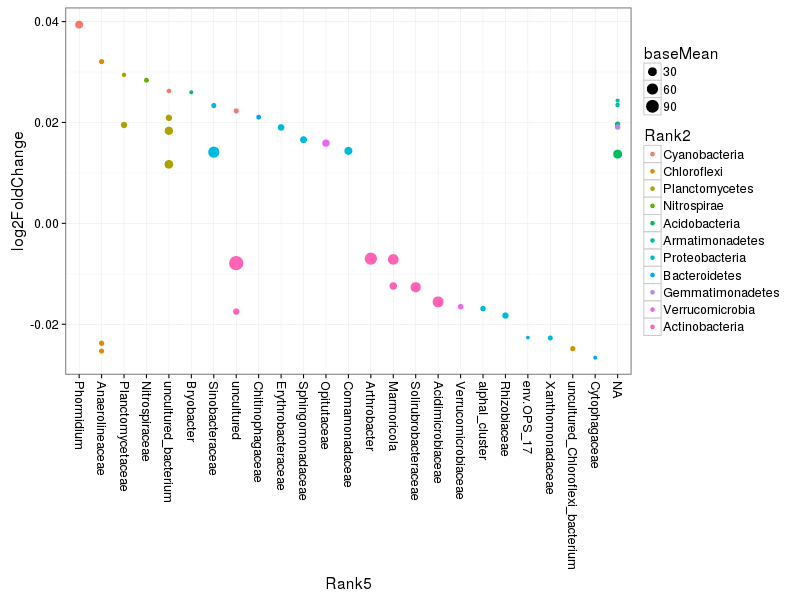

In [43]:
%%R -w 800 -h 600
sigtab1 = DF %>% filter(padj < 0.05)
x = tapply(sigtab1$log2FoldChange, sigtab1$Rank2, function(x) max(x))
x = sort(x, TRUE)
sigtab1$Rank2 = factor(as.character(sigtab1$Rank2), levels=names(x))
x = tapply(sigtab1$log2FoldChange, sigtab1$Rank5, function(x) max(x))
x = sort(x, TRUE)
sigtab1$Rank5 = factor(as.character(sigtab1$Rank5), levels=names(x))
    
ggplot(sigtab1, aes(x=Rank5, y=log2FoldChange, color=Rank2, size = baseMean)) + 
    geom_point() +
    theme_bw(base_size = 16) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))
#x = tapply(sigtab$log2FoldChange, sigtab$Rank2, function(x) max(x))
#x = sort(x, TRUE)
#x

## which OTUs are first order reponders in both 

In [42]:
%%R
dim(sigtab1)

[1] 39 15


In [44]:
%%R

colnames(sigtab1)[1:14] = paste("Bare_", colnames(sigtab1)[1:14], sep = "")
head(sigtab1)
Time1 = full_join(sigtab, sigtab1, by = "OTU")

In [46]:
%%R
colnames(Time1)
Time1[, c(15, 1,2, 6, 21)]

          OTU    baseMean log2FoldChange         padj    Bare_padj
1    OTU.2009   0.4054669     0.05046245 1.931610e-02           NA
2    OTU.1285   1.6927025    -0.04257980 2.759200e-03           NA
3    OTU.3513   0.4734190    -0.04051157 2.946442e-02           NA
4    OTU.6694   0.7131290     0.04585132 9.419972e-03           NA
5     OTU.377   7.7015874    -0.01863789 1.114131e-02           NA
6    OTU.2903   0.4670149     0.04594117 2.375509e-02           NA
7    OTU.1236   4.4038873     0.03584182 6.674810e-04           NA
8     OTU.671   5.1733604     0.02182144 3.486921e-02           NA
9    OTU.2917   0.5313061    -0.07206572 2.639594e-04           NA
10   OTU.2992   0.5745589    -0.05767656 6.138099e-04           NA
11    OTU.902   3.6249399    -0.07979833 7.796599e-07           NA
12   OTU.2107   0.7743774    -0.06106632 1.891251e-04           NA
13   OTU.2954   0.6196896    -0.06940700 1.201664e-04           NA
14   OTU.3004   0.9153119    -0.06111990 9.267532e-04         

# Deseq time course

In [48]:
%%R
sample_data(physeq.Full)$DAP = as.factor(sample_data(physeq.Full)$DAP)
ddsTC <- phyloseq_to_deseq2(physeq.Full, ~ Library + Planted + DAP + Planted:DAP) 


In [49]:
%%R
ddsTC <- DESeq(ddsTC, test="LRT", reduced = ~ Planted + DAP)
resTC <- results(ddsTC)
resTC$symbol <- mcols(ddsTC)$symbol
head(resTC[order(resTC$padj),],4)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: gene-wise dispersion estimates

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: final dispersion estimates

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 10 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: -- replacing outliers and refitting for 18 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


log2 fold change (MLE): PlantedRhizosphere.DAP88 
LRT p-value: '~ Library + Planted + DAP + Planted:DAP' vs '~ Planted + DAP' 
DataFrame with 4 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat       pvalue
          <numeric>      <numeric> <numeric> <numeric>    <numeric>
OTU.10352  24.65281   -0.063587828 0.2951859  188.9375 1.362466e-36
OTU.70     39.92026    0.557029665 0.3447859  179.0157 1.656927e-34
OTU.20    143.76100   -0.214451709 0.9813409  132.3932 9.023456e-25
OTU.32     98.89416    0.003185129 0.2735394  118.5000 6.763062e-22
                  padj
             <numeric>
OTU.10352 6.107933e-33
OTU.70    3.714003e-31
OTU.20    1.348405e-21
OTU.32    7.579702e-19


In [64]:
%%R

#ddsTC$rowData

NULL


In [58]:
%%R
Gs = resTC[order(resTC$padj),] %>% .[1:10,]
data <- plotCounts(ddsTC, 45, 
                   intgroup=c("DAP","Planted"), returnData=TRUE)

In [60]:
%%R

data <- plotCounts(ddsTC, 10352, 
                   intgroup=c("DAP","Planted"), returnData=TRUE)
ggplot(data, aes(x=DAP, y=count, color=Planted, group=Planted)) + 
  geom_point() + stat_smooth(se=FALSE,method="loess") +  scale_y_log10() + facet_wrap


Error: length(gene) == 1 & (is.character(gene) | (is.numeric(gene) &  .... is not TRUE


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error: length(gene) == 1 & (is.character(gene) | (is.numeric(gene) &  .... is not TRUE

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [51]:
%%R
betas <- coef(ddsTC)
colnames(betas)

 [1] "Intercept"                   "Library"                    
 [3] "Planted_Rhizosphere_vs_BARE" "DAP_53_vs_36"               
 [5] "DAP_57_vs_36"                "DAP_61_vs_36"               
 [7] "DAP_72_vs_36"                "DAP_79_vs_36"               
 [9] "DAP_84_vs_36"                "DAP_88_vs_36"               
[11] "PlantedRhizosphere.DAP53"    "PlantedRhizosphere.DAP57"   
[13] "PlantedRhizosphere.DAP61"    "PlantedRhizosphere.DAP72"   
[15] "PlantedRhizosphere.DAP79"    "PlantedRhizosphere.DAP84"   
[17] "PlantedRhizosphere.DAP88"   


In [53]:
%%R
#library("pheatmap")
topGenes <- head(order(resTC$padj),20)
mat <- betas[topGenes, -c(1,2)]
thr <- 3 
mat[mat < -thr] <- -thr
mat[mat > thr] <- thr
heatmap(mat, breaks=seq(from=-thr, to=thr, length=101),
         cluster_col=FALSE)


Error in image.default(1L:nc, 1L:nr, x, xlim = 0.5 + c(0, nc), ylim = 0.5 +  : 
  must have one more break than colour


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in image.default(1L:nc, 1L:nr, x, xlim = 0.5 + c(0, nc), ylim = 0.5 +  : 
  must have one more break than colour

  res = super(Function, self).__call__(*new_args, **new_kwargs)
